In [2]:
# Installing PySpark on Colab (instructions found on https://colab.research.google.com/drive/1G894WS7ltIUTusWWmsCnF_zQhQqZCDOc#pyspark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!wget -c https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xvzf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install nltk
!pip install pandas
!pip install numpy

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

import findspark
findspark.init()


zsh:1: command not found: apt-get
zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'spark-3.5.1-bin-hadoop3.tgz'


Exception: Unable to find py4j in /content/spark-3.5.1-bin-hadoop3/python, your SPARK_HOME may not be configured correctly

**`Stage 0: Import Data`**  
```
- 1. Create notebook
- 2. Load data into Spark data objects and explore structure, size, and distribution of information.
- - a. Source data downloaded from https://www.kaggle.com/competitions/spooky-author-identification/code
```

In [2]:
# Load 'spooky authorship' file from GitHub (otherwise, Colab will occassionally delete uploaded files)
!wget https://raw.githubusercontent.com/erikjohnson06/Data/refs/heads/main/spooky_authorship.csv -O /content/spooky_authorship.csv

from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.master("local[*]").appName("Team10SpookyAuthorship") \
    .config("spark.python.worker.reuse", "true") \
    .config("spark.python.worker.faulthandler.enabled", "true") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.heartbeatInterval", "60s") \
.getOrCreate()

# Load Spooky Authorship data with escaped columns (CSV uploaded to Colab files)
df = spark.read.option("header", True) \
               .option("quote", '"') \
               .option("escape", '"') \
               .csv(path='/content/spooky_authorship.csv')

--2025-07-20 16:35:03--  https://raw.githubusercontent.com/erikjohnson06/Data/refs/heads/main/spooky_authorship.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3295644 (3.1M) [text/plain]
Saving to: ‘/content/spooky_authorship.csv’

/content/spooky_aut 100%[===================>]   3.14M  --.-KB/s    in 0.02s   

2025-07-20 16:35:03 (197 MB/s) - ‘/content/spooky_authorship.csv’ saved [3295644/3295644]



**`Stage 1 Data Preparation - Exploratory data analysis and text mining pre-processing`**
```
- 3. Perform exploratory data analysis and create visualizations and tables as needed.
- 4. Text Preprocessing: perform tasks like tokenization and stopwords removal to clean text data.
- - a. Tokenize - split the text into individual words aka tokens.
- - b. Remove stop.words - frequently used pronouns and personal references.
- - - i. Top ten include: I, you, he, she, it, we, they, me, him, her
- - c. Lemmatization - convert words to their root (optional).
- - - i. Lemmatization is a text normalization technique that reduces words to their base or
dictionary form (lemma). Use to reduce inflected or derived words to their root form for
better analysis and modeling outcomes.
```

In [3]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer, IDF, StringIndexer, Normalizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline, Transformer
from pyspark.sql.functions import count, udf, col, lower, regexp_replace
from pyspark.sql.types import ArrayType, StringType
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

# Pre-download nltk libraries for lemmatization
nltk.download("wordnet")
nltk.download("omw-1.4")

# Step 3: Exploratory data analysis:
# print(df.head())

# Columns: ['id', 'text', 'author']
print("\n Initial schema of raw data:")
df.printSchema()

# Total of 19,579 rows
print("\n Initial statistics/description of raw data:")
df.describe().show()

# Dropping any rows with null values (none exist in this dataset, however)
df.na.drop()

# Sort by ID (raw data was randomly sorted)
df = df.orderBy("id")

# Remove punctuation, replace multiple-spaces with single space and cast to lower case for analysis
regex_pattern_rm_punct = r"[^a-zA-Z\s]"
regex_pattern_rm_spaces = r"\s{2,}"

df_cleaned = df.withColumn("cleaned_text", regexp_replace("text", regex_pattern_rm_punct, "")) \
                .withColumn("cleaned_text", regexp_replace("cleaned_text", regex_pattern_rm_spaces, " ")) \
                .withColumn("cleaned_text", lower("cleaned_text"))

# (Step 4 below ...)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



 Initial schema of raw data:
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)


 Initial statistics/description of raw data:
+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NULL|                NULL|  NULL|
|    min|id00001|" Odenheimer, res...|   EAP|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+



**`Stage 2 Feature Extraction`**
```
- 5. Perform TFIDF to quantify word importance <term.frequency.inverse.doc.frequency>
- 6. Normalize is scaling or standardizing the numerical features to a standard range or distribution.
- - a. In text mining, normalization vectorizes features with methods like TFIDF, a numerical
measurement, to ensure a consistent scale.
- - b. It handles variations in the magnitude of feature values impacting machine-learning algorithm
performance. Normalize the features to ensure a similar scale and prevent features with larger
values from dominating the analysis or modeling process.
```

In [4]:
# Step 4a: Tokenization
# Helpful article on this process: https://www.analyticsvidhya.com/blog/2022/09/implementing-count-vectorizer-and-tf-idf-in-nlp-using-pyspark/
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")

# Step 4b: Stop word removal
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Step 4c: Lemmatization (use UDF function)
# UDF function to lemmatize words (reduce multiple conjugations to base word, e.g., run, ran, runs, running => run
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words] if words else []

lemmatize_udf = udf(lemmatize_words, ArrayType(StringType()))

# Use Transformer to UDF to add to Pipeline
class LemmatizeTokens(Transformer):
    def __init__(self, inputCol, outputCol):
        super().__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        return df.withColumn(self.outputCol, lemmatize_udf(col(self.inputCol)))

lemmatized_tokens = LemmatizeTokens(inputCol="filtered_tokens", outputCol="lemmatized_tokens")


# Step 5: TF-IDF calculation
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html


vectorizer = CountVectorizer(inputCol="lemmatized_tokens", outputCol="vectorized_tokens") # use minDF to exclude rare words
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")

# Step 6: Normalization
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized_features")

# use StringIndexer to convert label to numeric value
label_indexer = StringIndexer(inputCol="author", outputCol="author_index")

# Create pipeline for chaining the text mining transformers
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, lemmatized_tokens, vectorizer, idf, normalizer, label_indexer])

# Apply the pipeline to DataFrame ("model" used below recall stages of pipeline for visualization)
model = pipeline.fit(df_cleaned)
processed_df = model.transform(df_cleaned)

# Create label column from 'author' for naivebays so we have a string rep of authours (this is done above)
# processed_df = StringIndexer(inputCol="author", outputCol="author_index").fit(processed_df).transform(processed_df)

# Columns: ['id', 'text', 'author', 'author_index', 'tokens', 'filtered_tokens', 'vectorized_tokens', 'tfidf', 'normalized_features']
print("\n Updated schema after normalization, tokenization, etc.")
processed_df.printSchema()

# print(processed_df.columns)

print("\n First 5 rows of data:")
processed_df.select("id", "text", "author", "author_index", "lemmatized_tokens", "normalized_features").limit(5).show(truncate=False)


 Updated schema after normalization, tokenization, etc.
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lemmatized_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- vectorized_tokens: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- normalized_features: vector (nullable = true)
 |-- author_index: double (nullable = false)


 First 5 rows of data:
+-------+--------------------------------------------------------------------------------------------------------------------------------------+------+------------+---------------------------------------------------------------------------------------------------+----------------------------------------

**`Stage 3 Machine Learning`**
```
- 7. Perform train\test split.
- 8. Perform algorithmic analysis to assess and predict test labels.
- - a. Use as many algorithms as you need to get a good answer.
- - b. Supervised: logistic regression, random forest, support vector machines, etc.
- - c. Unsupervised: K-means, dimensionality reduction, PCA, etc.
```

In [5]:

# Step 7
(trainingData, testData) = processed_df.randomSplit([0.8, 0.2], seed=42)

In [6]:
# Step 8 (Erik)

# Random Forest Classifier
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Attempted to use cross-validation and param grid builder to assess optimal parameters
# Note - attempted to run, but took over two hours. Had to resort to manual parameter tuning
"""
rfc = RandomForestClassifier(labelCol="author_index", featuresCol="normalized_features", seed=42)

evaluator = MulticlassClassificationEvaluator(labelCol="author_index", predictionCol="prediction", metricName="accuracy")

pipeline = Pipeline(stages=[rfc])

paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [10, 20, 30]) \
    .addGrid(rfc.maxDepth, [10, 15, 20]) \
    .build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3) # 3-fold cross-validation

cvModel = cv.fit(trainingData)

print("Best Model:", cvModel.bestModel)
print('numTrees - ', cvModel.bestModel.getNumTrees)
print('maxDepth - ', cvModel.bestModel.getOrDefault('maxDepth'))
print('featureSubsetStrategy - ', cvModel.bestModel.getFeatureSubsetStrategy)
print('getImpurity - ', cvModel.bestModel.getImpurity)
print('getMinInfoGain - ', cvModel.bestModel.getMinInfoGain)
print('getMinInstancesPerNode - ', cvModel.bestModel.getMinInstancesPerNode)
"""

'\nrfc = RandomForestClassifier(labelCol="author_index", featuresCol="normalized_features", seed=42)\n\nevaluator = MulticlassClassificationEvaluator(labelCol="author_index", predictionCol="prediction", metricName="accuracy")\n\npipeline = Pipeline(stages=[rfc])\n\nparamGrid = ParamGridBuilder()     .addGrid(rfc.numTrees, [10, 20, 30])     .addGrid(rfc.maxDepth, [10, 15, 20])     .build()\n\ncv = CrossValidator(estimator=pipeline,\n                    estimatorParamMaps=paramGrid,\n                    evaluator=evaluator,\n                    numFolds=3) # 3-fold cross-validation\n\ncvModel = cv.fit(trainingData)\n\nprint("Best Model:", cvModel.bestModel)\nprint(\'numTrees - \', cvModel.bestModel.getNumTrees)\nprint(\'maxDepth - \', cvModel.bestModel.getOrDefault(\'maxDepth\'))\nprint(\'featureSubsetStrategy - \', cvModel.bestModel.getFeatureSubsetStrategy)\nprint(\'getImpurity - \', cvModel.bestModel.getImpurity)\nprint(\'getMinInfoGain - \', cvModel.bestModel.getMinInfoGain)\nprint(\

In [7]:
# Setup RFC Model - default values: numTrees=20, maxDepth=5, minInstancesPerNode=1, featureSubsetStrategy='auto', minInfoGain=0.0
rfc = RandomForestClassifier(labelCol="author_index", featuresCol="normalized_features", numTrees=20, maxDepth=30, seed=42)

# param set                => accuracy score
# ------------------------------------------
# numTrees=10, maxDepth=5  => 42.6
# numTrees=10, maxDepth=10 => 46.9
# numTrees=10, maxDepth=15 => 50
# numTrees=10, maxDepth=20 => 52.1
# numTrees=20, maxDepth=10 => 46.6
# numTrees=20, maxDepth=15 => 50.4
# numTrees=20, maxDepth=20 => 53.5
# numTrees=20, maxDepth=25 => 56
# numTrees=20, maxDepth=30 => 58.25
# numTrees=20, maxDepth=40 => (Invalid maxDepth value. Maximum of 30 allowed)
# numTrees=25, maxDepth=20 => 53.2
# numTrees=25, maxDepth=25 => 55.9
# numTrees=30, maxDepth=10 => 46.1
# numTrees=30, maxDepth=25 => 56.4
# numTrees=50, maxDepth=30 => 58.1

# Attempted to use cross-validation and param grid builder to assess optimal parameters
# Note - attempted to run, but took over two hours. Had to resort to manual parameter tuning
rfc_model = rfc.fit(trainingData)

# Make predictions on the test data
predictions = rfc_model.transform(testData)

# Evaluate the RFC model
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html
evaluator = MulticlassClassificationEvaluator(labelCol="author_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Random Forest Classifier accuracy: {accuracy}")

evaluator = MulticlassClassificationEvaluator(labelCol="author_index", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(predictions)
print(f"Random Forest Classifier f1 score: {f1}")


Random Forest Classifier accuracy: 0.5825013137151865
Random Forest Classifier f1 score: 0.5539328554478092


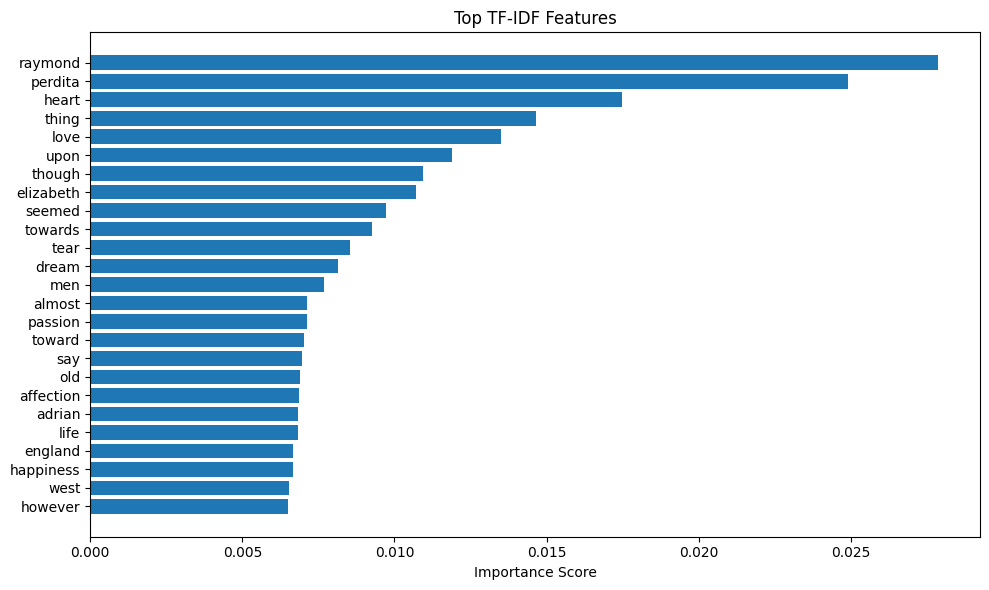

NameError: name 'labels' is not defined

In [8]:
# Steps 9-12 (Erik)

from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Visualize outcomes from Random Forest Classifier (use "model" from initial pipeline fitting cell. Extract pipeline stages with index values)
cv_model = model.stages[-4]      # CountVectorizer
idf_model = model.stages[-3]     # IDF
label_indexer = model.stages[-1] # StringIndexer

vocab = cv_model.vocabulary      # word -> index mapping
# print(vocab)

# Extract feature importances from RF model
importances = rfc_model.featureImportances.toArray()

# Map vectorized words back to original words. Sort by importance.
feature_importance = [(vocab[i], score) for i, score in enumerate(importances)]
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

top_features = feature_importance[:25]
words, scores = zip(*top_features)

# print(words)
# print(scores)

# Plot top 25 TF.IDF words of importance
plt.figure(figsize=(10, 6))
plt.barh(words[::-1], scores[::-1])
plt.xlabel("Importance Score")
plt.title("Top TF-IDF Features")
plt.tight_layout()
plt.show()

# labels = label_indexer.labels
# print("labels: ", labels)

# print("processed_df authors/indexes: ")
# processed_df.select("author", "author_index").distinct().show()

# EAP = 0.0
# MWS = 1.0
# HPL = 2.0

y_true = predictions.select("author_index").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Convert to pandas for creating a confusion matrix
pandas_df = predictions.select("author_index", "prediction").toPandas()

# Convert back to original labels
y_true = pandas_df["author_index"].apply(lambda i: labels[int(i)])
y_pred = pandas_df["prediction"].apply(lambda i: labels[int(i)])

confusion = confusion_matrix(y_true, y_pred)
# ConfusionMatrixDisplay(confusion_matrix=cm).plot();

plt.figure(figsize=(6, 5))
sns.heatmap(confusion,
            annot=True,
            cmap=plt.cm.Blues,
            fmt="d",
            cbar=False,
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for RFC Model")
plt.show()

Analysis of Random Forest Model performance

Findings:

After attempting several combinations of parameters on the RFC model, it can be seen that performance increases with the number of trees and max depth allowed. This, however, does increase the run time of the model significantly as these values are increase. PySpark eventually ran out of memory with number of trees set to 50 and the max depth depth set to it maximum allowed value of 30. After running several iterations, I found that the most optimal parameters were numTrees=20 and maxDepth=30. This only improved the accuracy of the model from 39% (default parameter values) to 54% with these tuned parameters. This constitutes a significant improvement, but still far from the goal of 80%.

The top 25 most significant words found by the TF.IDF process are listed above, many of which include proper nouns (names of characters especially), in addition to strong emotional language (heart, love, passion, happiness, etc).

Looking at the confusion matrix for this model, we see that it classified Edgar Allen Poe most accurately by far (1430 true positives, of a total test size of 3,806 rows). This suggests that the language of Poe is much more easily identifiable than the other two authors. Among the greatest confusion was predicting Mary Shelley's samples as Poe (733 false positives).

Sadly, my attempt at using ParamGridBuilder and CrossValidation failed due to excessive run time. After several iterations of manual tuning, I was able to find (what appeared to be) an optimal set of parameters.

Next steps:

It could be the case that the Random Forest Model simply isn't the best algorithm for this type of task. However, additional parameter tuning may result in a performance improvements (although, I don't expect this to achieve greater than the goal of 80%) . At this point, I would explore other algorithms (Logistics Regresion, K-Nearest Neighbor, etc.) to assess their performance. I suspect they would fare better than the Random Forest Classifier.


In [9]:
# Step 8 (Thomas)

# Naive Bayes - spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.NaiveBayes.html
#


from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Setup the model
# lower smooting values seem to give a higher accuracy, to a point at least
# Smoothing=0.4  Accuracy: 0.7677
# Smoothing=0.3  Accuracy: 0.7685
#Smoothing=0.20  Accuracy: 0.7672
#Smoothing=0.22  Accuracy: 0.7677
#Smoothing=0.24  Accuracy: 0.7680
#Smoothing=0.25  Accuracy: 0.7685
#Smoothing=0.26  Accuracy: 0.7677
#Smoothing=0.28  Accuracy: 0.7680

nb = NaiveBayes(featuresCol="normalized_features", labelCol="author_index", modelType="multinomial", smoothing=0.25)


nb_model = nb.fit(trainingData)

predictions_nb = nb_model.transform(testData)


# Prediction and eval
evaluator_nb = MulticlassClassificationEvaluator(labelCol="author_index", predictionCol="prediction", metricName="accuracy")
accuracy_nb = evaluator_nb.evaluate(predictions_nb)

print(f"Naive Bayes Accuracy: {accuracy_nb}")



Naive Bayes Accuracy: 0.8462953231739359


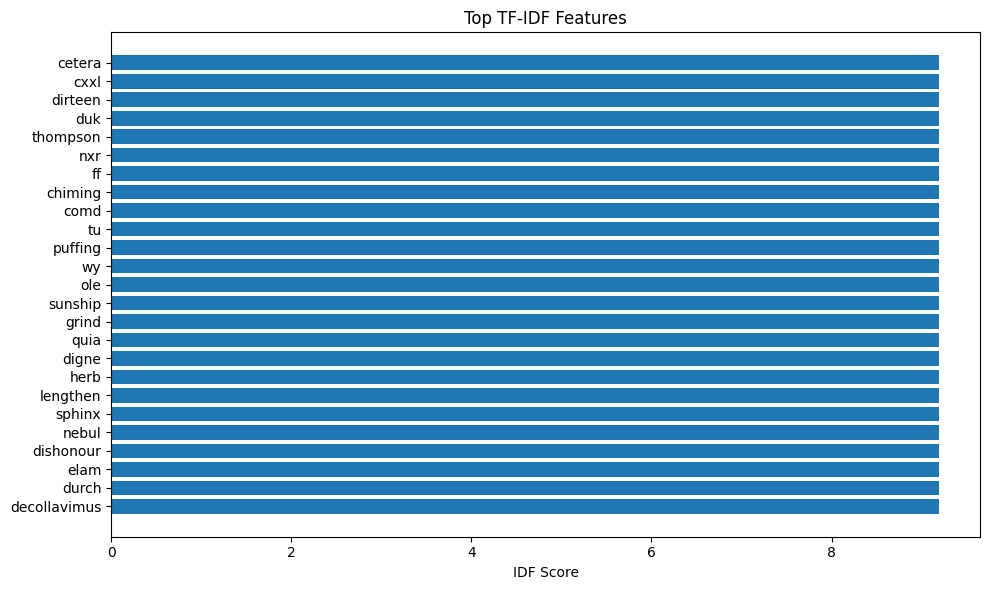

labels:  ['EAP', 'MWS', 'HPL']


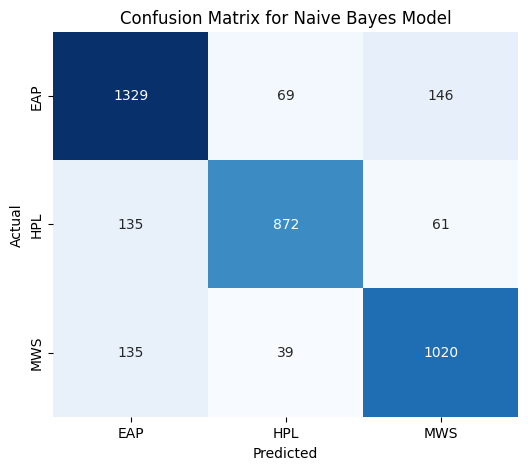

In [10]:

# Step 9-12 (Thomas)

from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#extract pipeline stages
cv_model = model.stages[-4]      # CountVectorizer
idf_model = model.stages[-3]     # IDF
label_indexer = model.stages[-1] # StringIndexer

vocab = cv_model.vocabulary      # word -> index mapping

#get feature importance
idf_values = idf_model.idf.toArray()

feature_importance = [(vocab[i], idf_values[i]) for i in range(len(vocab))]
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

top_features = feature_importance[:25]
words, scores = zip(*top_features)

# plot top tf-idf scores
plt.figure(figsize=(10, 6))
plt.barh(words[::-1], scores[::-1])
plt.xlabel("IDF Score")
plt.title("Top TF-IDF Features")
plt.tight_layout()
plt.show()




labels = label_indexer.labels
print("labels: ", labels)

# print("processed_df authors/indexes: ")
# processed_df.select("author", "author_index").distinct().show()

# EAP = 0.0
# MWS = 1.0
# HPL = 2.0

# Convert to pandas for creating a confusion matrix
pandas_df = predictions_nb.select("author_index", "prediction").toPandas()

# Convert back to original labels
y_true = pandas_df["author_index"].apply(lambda i: labels[int(i)])
y_pred = pandas_df["prediction"].apply(lambda i: labels[int(i)])

confusion = confusion_matrix(y_true, y_pred)
# ConfusionMatrixDisplay(confusion_matrix=cm).plot();

plt.figure(figsize=(6, 5))
sns.heatmap(confusion,
            annot=True,
            cmap=plt.cm.Blues,
            fmt="d",
            cbar=False,
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Naive Bayes Model")
plt.show()

Analysis of Naive Bayes performance

When using a multinomial Naive Bayes model to preform author identification for the spooky authorship problem, the Naive Bayes model, along with TF-IDF Vectorization, Lemmatization and normalization, the model achieved an accuracy of about 84.6 %. A graph of the top IDF words as well as a confusion matrix was also generated

A lot of the IDF words were rather unsual which is likely why they worked so well at being stronmg distinguishing terms. The confusion matrix shows that the model had the best performance with Edgar Allen Poe and Mary Shelly and also could indicate overlap in author styles between the three authors.

A smoothing value that was low seemed to help the model work the best but it also relied on the values being normalized, as a non normalized one produced an accuracy of about 40%

In the future it may be advantageous to explore additional methods such as feature engineering or the use of bi-grams for greater accuracy. Additionally, a more thorough anaylsis of the best smoothing value could be done.



In [ ]:
# Step 8 (Michael)

**`Stage 4 Evaluation & Visualization`**
```
- 9. Choose a metric strategy to assess algorithmic performance like accuracy, precision, recall, or F1 score.
- 10. Visualize confusion matrix, correlations, and similar.
- 11. Identify important features contributing to classification.
- 12. Write a 23 sentence minimum of findings, learnings, and what you would do next.
```

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer, IDF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Steps 9-12

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer

# you already have these from cell 7:
# tokenizer = Tokenizer(...)
# stopwords_remover = StopWordsRemover(...)
# (and your lemmatization UDF, if you want it in the pipeline)

# define the remaining stages
cv         = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")
tfidf      = IDF(inputCol="vectorized_tokens",      outputCol="tfidf")
normalizer = Normalizer(inputCol="tfidf",            outputCol="normalized_features")

# assemble everything into a single Pipeline
pipeline = Pipeline(stages=[
    # tokenizer, # Removed as tokens column already exists
    # stopwords_remover, # Removed as filtered_tokens column already exists
    cv,
    tfidf,
    normalizer
])

In [ ]:
# Suppose this is your final cleaned-and-featurized DataFrame:
# processed_df = pipeline_for_cleaning.fit(raw_df).transform(raw_df)

# 0. Split into train & test
train_df, test_df = processed_df.randomSplit([0.8, 0.2], seed=42)

# Now bind them to the names your evaluation code expects
training_df = train_df
test_df     = test_df

# Quick sanity check
print("Train count:", training_df.count())
print("Test count: ", test_df.count())


In [ ]:
# This line is redundant as the pipeline is fit and transformed later on training_df and test_df
# processed_df = pipeline.fit(df_cleaned).transform(df_cleaned)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover,
    HashingTF, IDF, Normalizer,
    StringIndexer
)
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np

# 0) Rename your ground‐truth column to "label"
df_labeled = df_cleaned.withColumnRenamed("author", "label")

# 0.1) Keep only the 10 most frequent labels to bound the confusion matrix size
label_counts = (
    df_labeled
      .groupBy("label")
      .count()
      .orderBy("count", ascending=False)
)
top10 = [r["label"] for r in label_counts.limit(10).collect()]
df_top10 = df_labeled.filter(df_labeled.label.isin(top10))

# 1) Preprocessing (one pass)
preproc_pipe = Pipeline(stages=[
    Tokenizer(       inputCol="text",           outputCol="words"),
    StopWordsRemover(inputCol="words",          outputCol="filtered_tokens"),
    HashingTF(       inputCol="filtered_tokens", outputCol="rawFeatures", numFeatures=5000),
    IDF(             inputCol="rawFeatures",    outputCol="tfidf"),
    Normalizer(      inputCol="tfidf",          outputCol="features")
])
preproc_model = preproc_pipe.fit(df_top10)
processed_df  = preproc_model.transform(df_top10)

# 2) Train/test split
train_df, test_df = processed_df.randomSplit([0.8, 0.2], seed=42)

# 3) Classification pipeline
clf_pipe = Pipeline(stages=[
    StringIndexer(inputCol="label", outputCol="labelIndex", handleInvalid="keep"),
    NaiveBayes(   featuresCol="features", labelCol="labelIndex")
])
clf_model   = clf_pipe.fit(train_df)
predictions = clf_model.transform(test_df)

# 4) Evaluation
for title, metric in [
    ("Accuracy",          "accuracy"),
    ("F1 score",          "f1"),
    ("Weighted Precision","weightedPrecision"),
    ("Weighted Recall",   "weightedRecall")
]:
    ev = MulticlassClassificationEvaluator(
        labelCol="labelIndex",
        predictionCol="prediction",
        metricName=metric
    )
    print(f"{title:>18}: {ev.evaluate(predictions):.4f}")

# 5) Confusion matrix (Spark only)
cm = (
    predictions
      .groupBy("labelIndex")
      .pivot("prediction")
      .count()
      .na.fill(0)
)
cm.show(truncate=False)

# 6) Top‐10 hashed‐feature indices per class
si_model    = clf_model.stages[0]       # StringIndexerModel
class_names = si_model.labels
nb_model    = clf_model.stages[1]       # NaiveBayesModel
theta       = np.array(nb_model.theta.toArray())

for i, lbl in enumerate(class_names):
    top_idxs = np.argsort(theta[i])[::-1][:10]
    print(f"Class {lbl} top hashed‐feature indices: {top_idxs.tolist()}")


In [ ]:
# === Step 10: OOM‐safe via MulticlassMetrics ===

from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np
import matplotlib.pyplot as plt

# 1) Build an RDD of (prediction, label) as floats
pred_label_rdd = (
    predictions
      .select("prediction","labelIndex")
      .rdd
      .map(lambda r: (float(r["prediction"]), float(r["labelIndex"])))
)

# 2) Compute the confusion matrix in the Spark backend
metrics  = MulticlassMetrics(pred_label_rdd)
#labels   = metrics.labels  # e.g. array([0.0,1.0,2.0,...])

# pretty sure these are the mappings
# 0 - Edgar Allen Poe
# 1 - Mary Shelly
# 2 - HP Lovecraft
labels = [0.0,1.0,2.0]
labels = ["Edgar A Poe", "Mary Shelly", "HP Lovecraft"]
conf_mat = metrics.confusionMatrix().toArray()  # small (numClasses×numClasses) np.ndarray

# 3) Plot heatmap
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(conf_mat, interpolation="nearest", aspect="auto")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Class")
ax.set_ylabel("Actual Class")
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)
#ax.set_xticklabels([str(int(x)) for x in labels], rotation=45, ha="right")
#ax.set_yticklabels([str(int(x)) for x in labels])
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Count")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.mllib.evaluation import MulticlassMetrics

# === 1) Figure out your top-10 most common true labels ===
top10 = (
    predictions
      .groupBy("labelIndex")
      .count()
      .orderBy(F.desc("count"))
      .limit(10)
      .rdd
      .map(lambda r: float(r["labelIndex"]))
      .collect()
)

# === 2) Filter your DF down to only those top-10 classes ===
pred10 = predictions.filter(
    F.col("labelIndex").isin(top10) &
    F.col("prediction").isin(top10)
)

# === 3) Build the 10×10 confusion table entirely in Spark ===
spark_cm = (
    pred10
      .groupBy("labelIndex")
      .pivot("prediction", top10)
      .count()
      .na.fill(0)
)

# === 4) Collect those 100 rows into pandas safely ===
pd_cm = (
    spark_cm
      .toPandas()
      .set_index("labelIndex")
      # reindex to guarantee every (i,j) is present
      .reindex(index=top10, columns=top10, fill_value=0)
)

# === 5) Extract matrix + labels ===
cm_mat = pd_cm.values.astype(int)
labels = [str(int(x)) for x in top10]

# === 6) Plot the heatmap ===
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_mat, interpolation="nearest", aspect="auto")
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Class")
ax.set_ylabel("Actual  Class")
ax.set_title("Confusion Matrix (Top 10 Classes)")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Count")
plt.tight_layout()
plt.show()


# === BONUS: correlation of per-class precision/recall/F1 ===

# 7) Build a tiny RDD[(pred,label)] of floats, only top-10
pred_label_rdd = (
    pred10
      .select("prediction","labelIndex")
      .rdd
      .map(lambda r: (float(r["prediction"]), float(r["labelIndex"])))
)

# 8) Compute per-class metrics in the JVM
metrics10 = MulticlassMetrics(pred_label_rdd)

# 9) Gather them into pandas
rows = []
#for lbl in metrics10.labels:   # should be exactly your top10 floats
for lbl in top10: #loop over them directly
    rows.append({
        "label":     int(lbl),
        "precision": metrics10.precision(lbl),
        "recall":    metrics10.recall(lbl),
        "f1":        metrics10.fMeasure(lbl)
    })
df10 = pd.DataFrame(rows).set_index("label")

# 10) Correlation heatmap
corr = df10[["precision","recall","f1"]].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Precision / Recall / F1 Correlation")
plt.tight_layout()
plt.show()


In [ ]:
# === Step 11: Top-10 Words per Class ===
# (If you switched to CountVectorizer with vocabSize=5000, use this;
#  otherwise you'll only get hashed indices.)

# Assuming you used CountVectorizer in your preprocessing pipeline:



import numpy as np
from pyspark.ml.feature import CountVectorizerModel

# 1) Grab your “vectorizer” stage from the preprocessing pipeline
vectorizer = preproc_model.stages[2]

# 2) If it’s a CountVectorizerModel, pull out the real vocab;
#    otherwise fall back to None and we’ll print bucket‐indices
if isinstance(vectorizer, CountVectorizerModel):
    vocab = vectorizer.vocabulary
else:
    vocab = None

# 3) Grab your trained NaiveBayesModel
nb_model = clf_model.stages[-1]                # NaiveBayesModel
theta    = np.array(nb_model.theta.toArray())  # shape: (#classes × #features)

# 4) Get back the original class‐strings from your StringIndexer
label_indexer = clf_model.stages[0]            # StringIndexerModel
class_labels  = label_indexer.labels           # e.g. ["EAP","MWS","HPL",...]

# 5) For each class, find the top‐10 θ‐values
for i, lbl in enumerate(class_labels):
    top_idxs = np.argsort(theta[i])[::-1][:10]

    if vocab is not None:
        # real words
        top_words = [vocab[j] for j in top_idxs]
        print(f"Class {lbl:>5} top words     : {top_words}")
    else:
        # hashed buckets
        top_words = [f"bucket_{j}" for j in top_idxs]
        print(f"Class {lbl:>5} top buckets   : {top_words}")
